# MNIST Revisited
Going back to the MNIST handwritten digit competition, this time in Jupyter with some new ideas.

## Load and Preprocess Data

In [1]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style; style.use('ggplot')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# setup all features (train and test features) and labels as np arrays
X = np.vstack((train_df.iloc[:, 1:].values, test_df.values))
y = train_df.iloc[:, 0].values

In [6]:
X.shape, y.shape

((70000, 784), (42000,))

In [7]:
np.min(X), np.max(X)

(0, 255)

In [8]:
# scale feature values to be in range 0 -> 1 (important for neural network classifier)
X = X / 255

In [9]:
np.min(X), np.max(X)

(0.0, 1.0)

In [10]:
# count the number of each digit in the dataset
print('Digit\tCount')

for i in range(10):
    print(i, '\t', np.sum(y == i))

Digit	Count
0 	 4132
1 	 4684
2 	 4177
3 	 4351
4 	 4072
5 	 3795
6 	 4137
7 	 4401
8 	 4063
9 	 4188


## PCA for Visualization

In [11]:
# pca to 2D
pca = PCA(n_components=2)
X_red = pca.fit_transform(X[:y.size, :])

In [12]:
X_red.shape

(42000, 2)

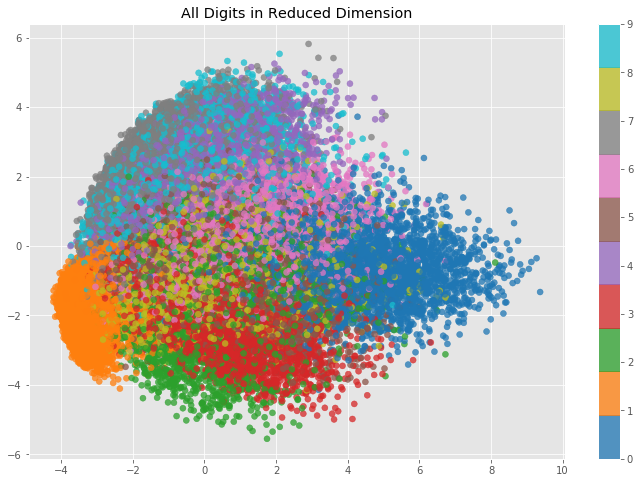

In [23]:
# plot light digits with labels represented by color
plt.rcParams['figure.figsize'] = [12, 8]

plt.scatter(X_red[:, 0], X_red[:, 1], c=y, alpha=.75, cmap='tab10')
plt.colorbar()
plt.title('All Digits in Reduced Dimension');

In [24]:
# make list of mean reduced features for digits
mean_ls = []

for i in range(10):
    mean_ls.append([np.mean(X_red[y == i][:, 0]), np.mean(X_red[y == i][:, 1])])
    
mean_arr = np.asarray(mean_ls)

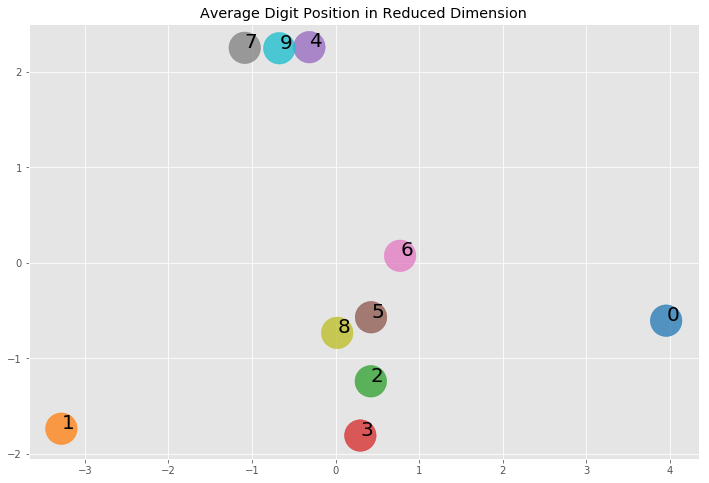

In [25]:
# plot mean values with annotations
plt.scatter(mean_arr[:, 0], mean_arr[:, 1], 
            c=range(10),
            alpha=.75,
            cmap='tab10',
            s=1000)

for i in range(10):
    plt.annotate(i, (mean_arr[i, 0], mean_arr[i, 1]), fontsize=20)

plt.title('Average Digit Position in Reduced Dimension');

## Visualize Digits

In [28]:
def show_digit(digit):
    """ Displays handwritten digit given input in form source[index] """
    plt.rcParams['figure.figsize'] = [3, 3]
    plt.imshow(digit.reshape(28, 28),cmap=plt.cm.binary)
    plt.axis('off')
    plt.show()
    return None

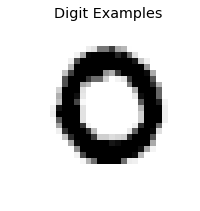

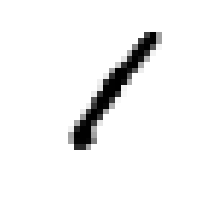

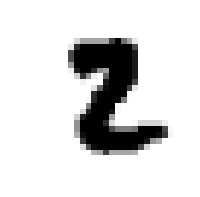

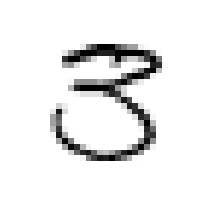

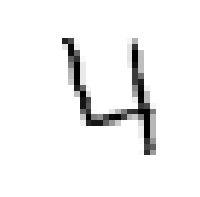

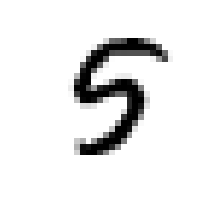

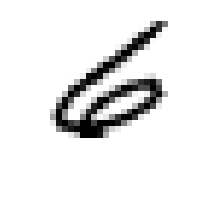

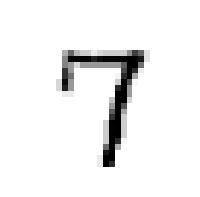

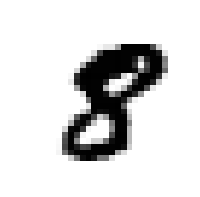

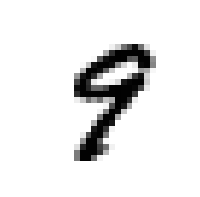

In [29]:
# show a single digit of each value
plt.title('Digit Examples')

for i in range(10):
    show_digit(X[np.where(y == i)[0][0]])

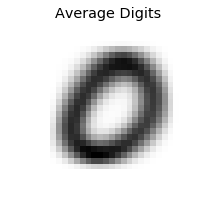

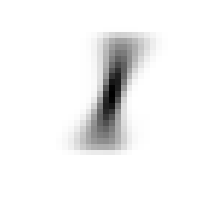

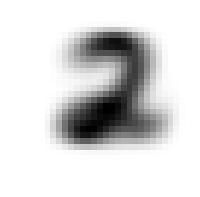

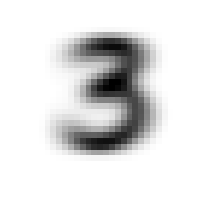

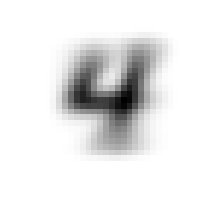

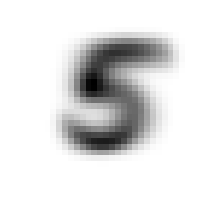

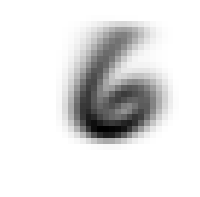

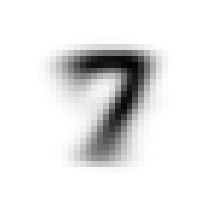

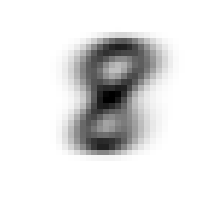

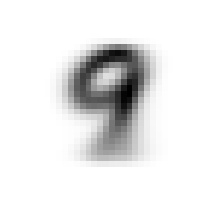

In [30]:
# show the average grid of each digit
plt.title('Average Digits')

for i in range(10):
    show_digit(np.sum(X[:y.size, :][y == i], axis=0) / np.sum(y == i))

## PCA to Improve Training Speed

In [31]:
# Use built-in functionality to choose dimension which preserves 99% of variance
pca = PCA(n_components=0.99, svd_solver='full')
X = pca.fit_transform(X)
np.sum(pca.explained_variance_ratio_), X.shape[1]

(0.9900550292572763, 331)

PCA reduces the number of features by a factor greater than 2, while still retaining 99% of the variance in the original dataset!

In [32]:
# split X into train (X) and test (X_test)
X_test = X[y.size:, :]    # this line must come first
X = X[:y.size, :]         # this line must come second

In [33]:
X.shape, X_test.shape

((42000, 331), (28000, 331))

## Build Neural Network Model

In [34]:
# train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

I will use a common neural network architecture -- one hidden layer, with the number of nodes between the number in the input and output layers.

This architecture consistently outperformed deeper networks in my testing.

In [35]:
# neural network
nn = MLPClassifier(hidden_layer_sizes=(170,), max_iter=1000)
nn.fit(X_train, y_train)
accuracy_score(y_val, nn.predict(X_val))

0.97

The network classifies digits in the validation set with a 97% accuracy. Let's see how it does on the test set!

## Make Predictions

In [36]:
# train network on entire train set (X) and make predictions on test set (X_test)
nn.fit(X, y)
predictions = nn.predict(X_test)

In [37]:
predictions.shape, predictions

((28000,), array([2, 0, 9, ..., 3, 9, 2]))

In [38]:
# set up columns to prepare for submission
predictions = predictions.reshape(-1, 1)
indices = (test_df.index.values + 1).reshape(-1, 1)

In [39]:
# submission format
submission = np.hstack((indices, predictions))
submission = np.vstack((np.array(['ImageId', 'Label']),
                      submission))

In [40]:
# save predictions
np.savetxt('MNIST_NN_Predictions.csv', 
           submission, 
           delimiter=',', 
           fmt='%s')

I ended up with an accuracy of 97.571% on Kaggle!